In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
# tf.keras.backend.clear_session()

Mounted at /content/gdrive


# **Brain Tumor Localization**

In [12]:
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

annotations_data = pd.read_csv("/content/gdrive/MyDrive/hichem_data/brain_tumor_detection_mri/train.csv")
print(annotations_data.head(10))

print("-----------------------------------------------------------------------")
annotations_info = annotations_data[["region_shape_attributes"]]
print(annotations_info)

print("-----------------------------------------------------------------------")
info_xy = annotations_info.values
print(info_xy[:10])


   filename  ...  region_attributes
0  img0.jpg  ...                 {}
1  img1.jpg  ...                 {}
2  img2.jpg  ...                 {}
3  img3.jpg  ...                 {}
4  img4.jpg  ...                 {}
5  img5.jpg  ...                 {}
6  img6.jpg  ...                 {}
7  img7.jpg  ...                 {}
8  img8.jpg  ...                 {}
9  img9.jpg  ...                 {}

[10 rows x 7 columns]
-----------------------------------------------------------------------
                               region_shape_attributes
0    {"name":"rect","x":249,"y":190,"width":73,"hei...
1    {"name":"rect","x":231,"y":51,"width":95,"heig...
2    {"name":"rect","x":228,"y":345,"width":79,"hei...
3    {"name":"rect","x":52,"y":258,"width":77,"heig...
4    {"name":"rect","x":213,"y":53,"width":111,"hei...
..                                                 ...
150  {"name":"rect","x":104,"y":35,"width":174,"hei...
151  {"name":"rect","x":78,"y":160,"width":90,"heig...
152  {"name":"

In [13]:
# Coordinates
coordinates = np.zeros( (len(info_xy), 4) )
indx = 0
for info in info_xy:
  elem = info[0].split(":")
  x_min = int(elem[2].split(",")[0])
  y_min = int(elem[3].split(",")[0])

  w = int(elem[4].split(",")[0]) 
  h = int(elem[5].split("}")[0]) 
  w,h = math.sqrt(w), math.sqrt(h)
  coordinates[indx,:] = [x_min,y_min, w, h]
  indx += 1

print(coordinates[:10])

print("----------------------------------------------------------------------") 
# Images 
filename = annotations_data[["filename"]] 
filename = filename.values

print(filename[:10])


[[249.         190.           8.54400375   8.42614977]
 [231.          51.           9.74679434   8.88819442]
 [228.         345.           8.88819442   8.24621125]
 [ 52.         258.           8.77496439   7.81024968]
 [213.          53.          10.53565375  12.76714533]
 [233.         163.          10.39230485  10.14889157]
 [129.         203.           8.66025404   8.30662386]
 [150.         121.           8.54400375   9.59166305]
 [130.         259.           8.71779789   7.93725393]
 [323.         199.           8.71779789   8.83176087]]
----------------------------------------------------------------------
[['img0.jpg']
 ['img1.jpg']
 ['img2.jpg']
 ['img3.jpg']
 ['img4.jpg']
 ['img5.jpg']
 ['img6.jpg']
 ['img7.jpg']
 ['img8.jpg']
 ['img9.jpg']]


Number of images :  155


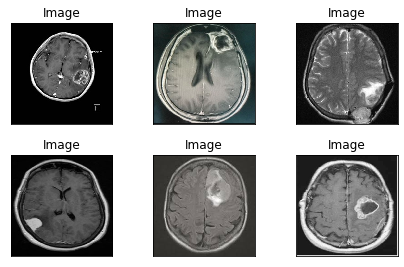

In [14]:
#*******************************************************************************
def read_images(data):
  lst_images = []
  for i in range(len(data)):
    img = cv2.imread(data[i])   
    lst_images.append(img)
  return lst_images
#*******************************************************************************

imgs_filename = []
for fn in filename :
  imgs_filename.append("/content/gdrive/MyDrive/hichem_data/brain_tumor_detection_mri/images/"+fn[0])

lst_imgs = read_images(imgs_filename)
print("Number of images : ", len(lst_imgs))

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout() 
  plt.imshow(lst_imgs[i], cmap='gray', interpolation='none')
  plt.title("Image")
  plt.xticks([])
  plt.yticks([])
fig.show()


In [15]:
# Scale the pixel intensities down to the [0,1] range by dividing them by 255.0 
# (this also converts them to floats).
X_train_raw, X_test_raw = lst_imgs[0:135], lst_imgs[135:155] 
X_train, X_test = np.asarray(X_train_raw), np.asarray(X_test_raw)

X_train = X_train.astype("float32")  
X_train = X_train / 255.0
X_test  = X_test.astype("float32")  
X_test  = X_test / 255.0

print("X_train : ",X_train.shape,"  X_test : ",X_test.shape)

# Normalize coordinates to 0-1 range
min_max_scaler = preprocessing.MinMaxScaler()
coordinates_scaled = min_max_scaler.fit_transform(coordinates).tolist()

y_train, y_test = coordinates_scaled[0:135], coordinates_scaled[135:155]
y_train, y_test = np.asarray(y_train), np.asarray(y_test)


X_train :  (135, 416, 416, 3)   X_test :  (20, 416, 416, 3)


# **CNN**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 416, 416, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 208, 208, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 208, 208, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 104, 104, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 104, 104, 250)     288250    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 52, 52, 250)       0         
_________________________________________________________________
flatten (Flatten)            (None, 676000)            0

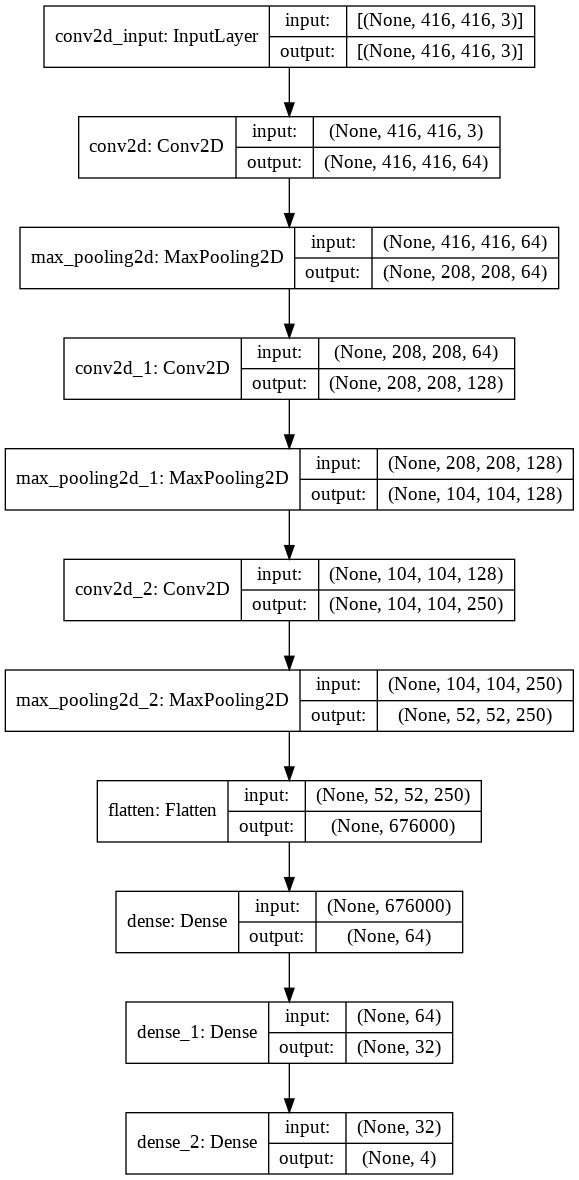

In [5]:
# Creating the model using the Sequential API
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, padding="same", 
                              activation="relu", input_shape= (416,416,3)))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same", 
                              activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=250, kernel_size=3, strides=1, padding="same", 
                              activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(4))

print(model.summary())

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)


In [8]:
# Compiling the model
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="mean_squared_error", optimizer=opt, metrics=["mse"])

# Training and evaluating the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
5/5 [==============================] - 47s 1s/step - loss: 98.1329 - mse: 98.1329
Epoch 2/100
5/5 [==============================] - 3s 641ms/step - loss: 0.2230 - mse: 0.2230
Epoch 3/100
5/5 [==============================] - 3s 640ms/step - loss: 0.1103 - mse: 0.1103
Epoch 4/100
5/5 [==============================] - 3s 635ms/step - loss: 0.0749 - mse: 0.0749
Epoch 5/100
5/5 [==============================] - 3s 634ms/step - loss: 0.0637 - mse: 0.0637
Epoch 6/100
5/5 [==============================] - 3s 634ms/step - loss: 0.0575 - mse: 0.0575
Epoch 7/100
5/5 [==============================] - 3s 634ms/step - loss: 0.0542 - mse: 0.0542
Epoch 8/100
5/5 [==============================] - 3s 632ms/step - loss: 0.0520 - mse: 0.0520
Epoch 9/100
5/5 [==============================] - 3s 635ms/step - loss: 0.0482 - mse: 0.0482
Epoch 10/100
5/5 [==============================] - 3s 637ms/step - loss: 0.0448 - mse: 0.0448
Epoch 11/100
5/5 [==============================] - 3s 632m

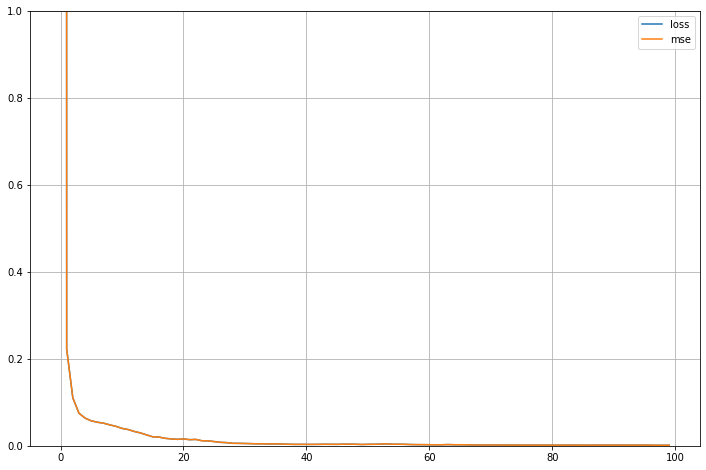

1/1 [==============================] - 5s 5s/step - loss: 0.0392 - mse: 0.0392
Loss                   :  [0.0392167791724205, 0.0392167791724205]


In [9]:
# plot the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# Evaluate the model
model_evaluate = model.evaluate(X_test, y_test)
print("Loss                   : ",model_evaluate)


Img :  0
y_test :  [203.0, 47.0, 11.313708498984761, 11.999999999999998]
pred   :  [126.29432678222656, 55.9415397644043, 10.698695182800293, 9.458002090454102]
IOU :  0.14


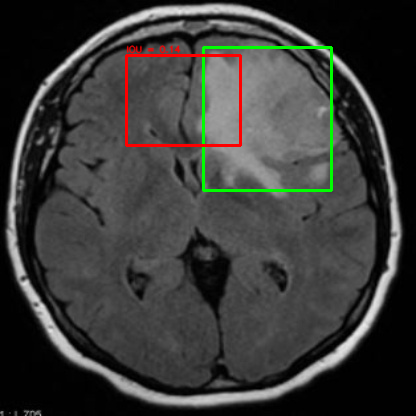

Img :  1
y_test :  [195.0, 77.0, 10.723805294763608, 11.532562594670797]
pred   :  [186.12559509277344, 112.297607421875, 10.05954647064209, 10.330601692199707]
IOU :  0.53


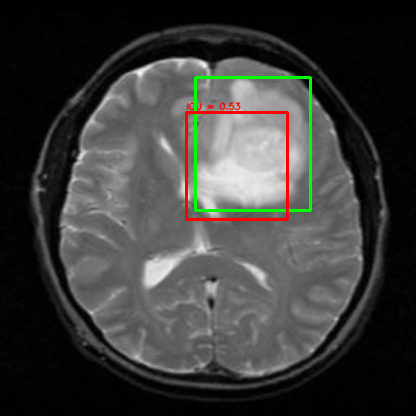

Img :  2
y_test :  [169.99999999999997, 212.99999999999997, 8.12403840463596, 7.937253933193771]
pred   :  [189.89962768554688, 134.88418579101562, 10.430200576782227, 10.295353889465332]
IOU :  0.09


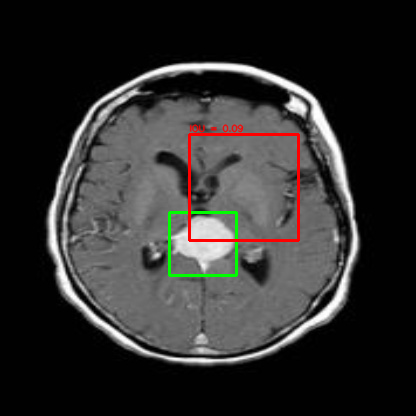

Img :  3
y_test :  [101.0, 229.0, 10.954451150103322, 11.789826122551595]
pred   :  [55.17368698120117, 120.71273803710938, 9.80954360961914, 9.6165189743042]
IOU :  0.0


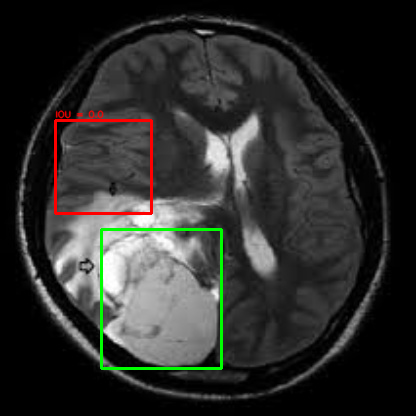

Img :  4
y_test :  [257.0, 302.0, 7.937253933193772, 7.615773105863909]
pred   :  [222.98565673828125, 121.83146667480469, 9.416620254516602, 10.056902885437012]
IOU :  0.0


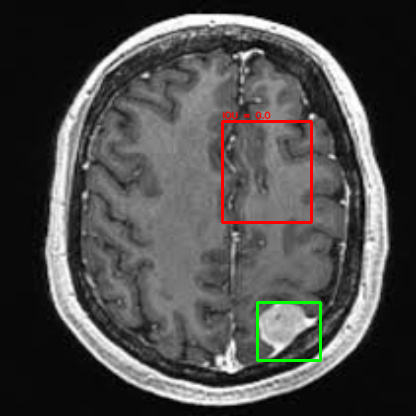

Img :  5
y_test :  [284.0, 126.0, 8.12403840463596, 6.855654600401044]
pred   :  [184.34971618652344, 139.02687072753906, 12.365252494812012, 11.918473243713379]
IOU :  0.08


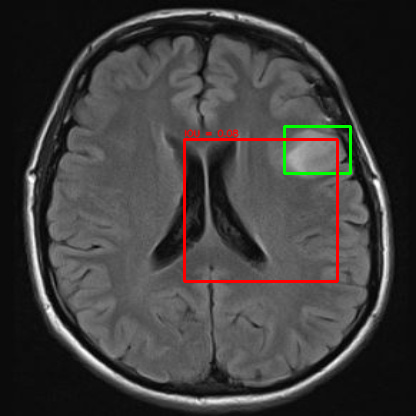

Img :  6
y_test :  [235.00000000000003, 182.0, 10.344080432788601, 11.999999999999998]
pred   :  [230.79290771484375, 183.08323669433594, 10.606030464172363, 11.90197467803955]
IOU :  0.93


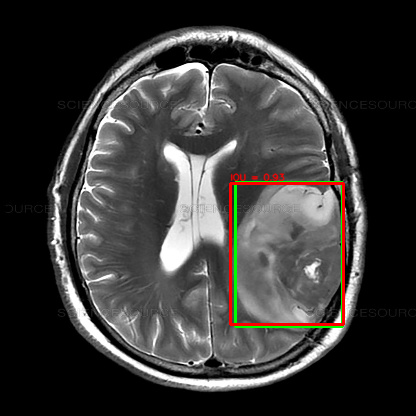

Img :  7
y_test :  [256.0, 225.0, 8.426149773176359, 8.831760866327848]
pred   :  [202.26380920410156, 150.79241943359375, 7.959606170654297, 7.395254611968994]
IOU :  0.0


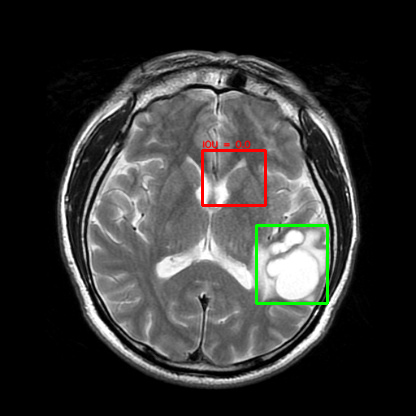

Img :  8
y_test :  [234.0, 212.99999999999997, 10.954451150103322, 10.14889156509222]
pred   :  [172.65493774414062, 190.72923278808594, 10.882293701171875, 10.577590942382812]
IOU :  0.25


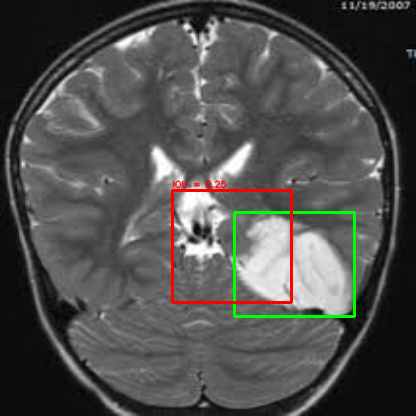

Img :  9
y_test :  [52.0, 141.0, 12.12435565298214, 11.313708498984763]
pred   :  [95.38446044921875, 85.2089614868164, 10.815157890319824, 10.340974807739258]
IOU :  0.21


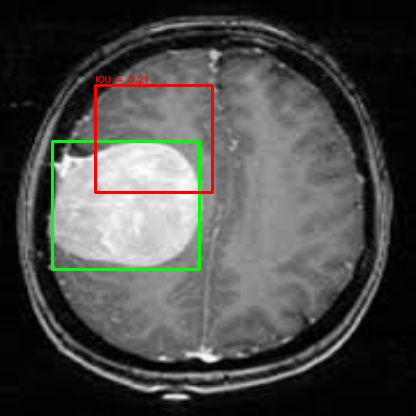

Img :  10
y_test :  [60.0, 74.0, 9.16515138991168, 10.63014581273465]
pred   :  [255.4464569091797, 124.85132598876953, 11.397990226745605, 11.87039566040039]
IOU :  0.0


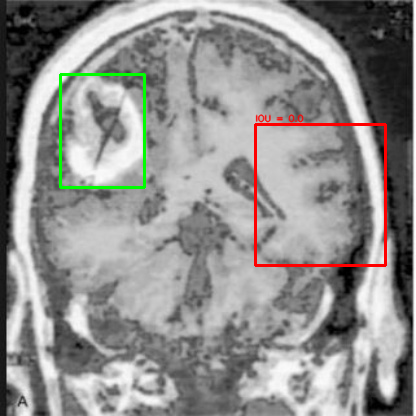

Img :  11
y_test :  [186.0, 79.0, 13.341664064126334, 12.083045973594574]
pred   :  [231.7899169921875, 160.7935333251953, 10.682829856872559, 11.87807559967041]
IOU :  0.22


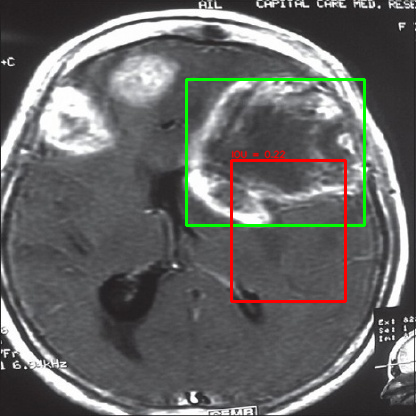

Img :  12
y_test :  [271.0, 202.0, 8.18535277187245, 7.280109889280518]
pred   :  [188.5978240966797, 152.68858337402344, 8.798431396484375, 8.75488567352295]
IOU :  0.0


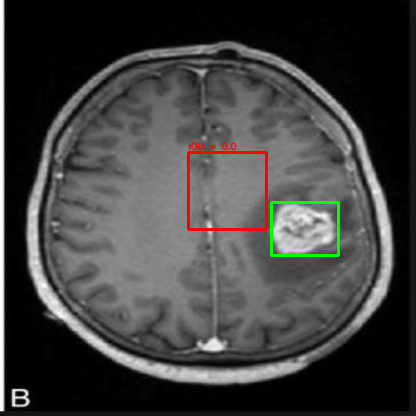

Img :  13
y_test :  [193.00000000000003, 94.0, 11.357816691600547, 11.269427669584644]
pred   :  [170.7567138671875, 91.73606872558594, 10.53475570678711, 10.949872970581055]
IOU :  0.53


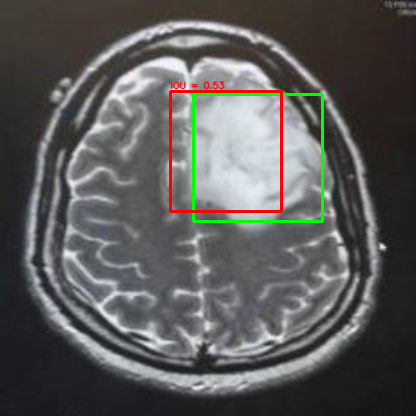

Img :  14
y_test :  [102.0, 127.00000000000001, 9.848857801796104, 11.313708498984763]
pred   :  [96.68965911865234, 127.3608169555664, 10.261630058288574, 11.547531127929688]
IOU :  0.89


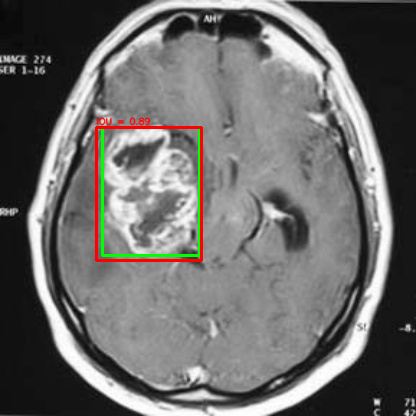

Img :  15
y_test :  [104.0, 35.0, 13.19090595827292, 12.328828005937952]
pred   :  [182.76368713378906, 75.91098022460938, 13.637139320373535, 14.594857215881348]
IOU :  0.19


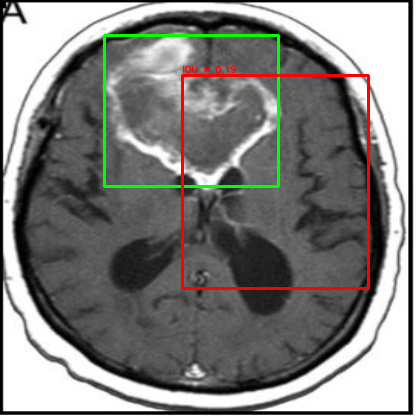

Img :  16
y_test :  [78.0, 160.0, 9.486832980505138, 11.532562594670797]
pred   :  [128.48353576660156, 94.4624252319336, 10.554852485656738, 9.675065994262695]
IOU :  0.05


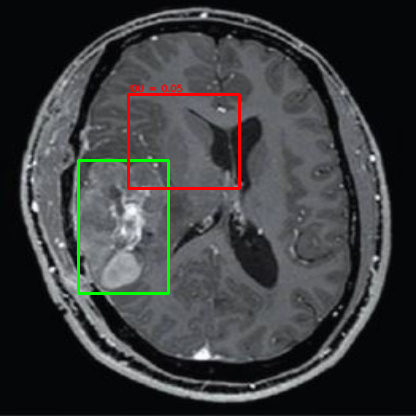

Img :  17
y_test :  [279.0, 161.0, 8.54400374531753, 9.591663046625438]
pred   :  [263.2606506347656, 154.6326446533203, 9.328214645385742, 10.160670280456543]
IOU :  0.72


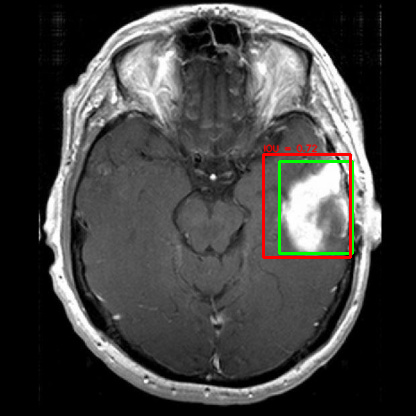

Img :  18
y_test :  [125.0, 182.0, 9.433981132056605, 9.486832980505138]
pred   :  [101.053466796875, 95.16789245605469, 9.084460258483887, 7.612806797027588]
IOU :  0.0


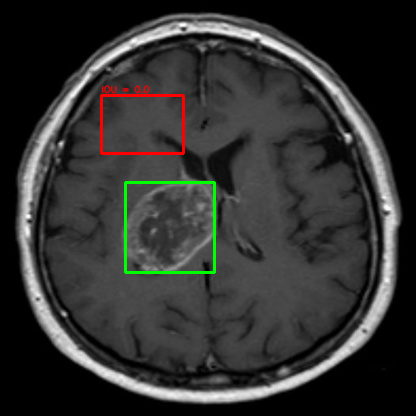

Img :  19
y_test :  [164.0, 292.0, 5.830951894845301, 6.164414002968976]
pred   :  [123.91534423828125, 271.5376281738281, 8.160325050354004, 7.427303791046143]
IOU :  0.22


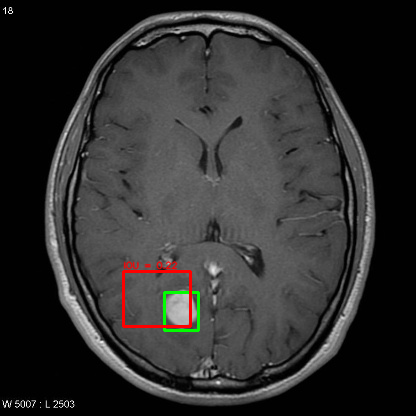

In [10]:
# Predict
pred = model.predict(X_test)

#*******************************************************************************
def intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

for ind in range(len(y_test)):
  image = X_test_raw[ind]
  box_test = y_test[ind]
  box_pred = pred[ind]
  
  box_test = box_test.reshape(1,-1)
  box_pred = box_pred.reshape(1,-1)
  box_test = min_max_scaler.inverse_transform(box_test).tolist()[0]
  box_pred = min_max_scaler.inverse_transform(box_pred).tolist()[0]
  
  print("Img : ",ind)
  print("y_test : ",box_test)
  print("pred   : ",box_pred)
  
  x_box_test, y_box_test = int(box_test[0]),int(box_test[1])
  w_box_test, h_box_test = int(box_test[0]+pow(box_test[2], 2)), int(box_test[1]+ pow(box_test[3], 2))

  x_box_pred, y_box_pred = int(box_pred[0]),int(box_pred[1])
  w_box_pred, h_box_pred = int(box_pred[0]+ pow(box_pred[2], 2)), int(box_pred[1]+ pow(box_pred[3], 2))

  boxA = [x_box_test, y_box_test, w_box_test, h_box_test]
  boxB = [x_box_pred, y_box_pred, w_box_pred, h_box_pred]
  
  #-----------------------------------------------------------------------------
  iou = intersection_over_union(boxA, boxB)
  print("IOU : ",round(iou, 2))
  label = "IOU = "+str(round(iou, 2))

  cv2.putText(image, label, (x_box_pred, y_box_pred-3), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,255),1,cv2.LINE_AA)	
  cv2.rectangle(image, (x_box_test, y_box_test), (w_box_test, h_box_test), (0,255,0), 2)
  cv2.rectangle(image, (x_box_pred, y_box_pred), (w_box_pred, h_box_pred), (0,0,255), 2)
  #image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
  cv2_imshow(image)	



# **TL**

In [ ]:
# Creating the model 

base_model = keras.applications.NASNetLarge(weights="imagenet",include_top=False,
                            input_tensor = keras.layers.Input(shape=(416, 416,3)))

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
layer_h1 = keras.layers.Dense(64, activation="relu")(avg)
layer_h2 = keras.layers.Dense(32, activation="relu")(layer_h1)
output   = keras.layers.Dense(4)(layer_h2)

model_tl = keras.Model(inputs=base_model.input, outputs=output)

"""
base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(weights=
                      "imagenet", include_top=False, input_tensor = keras.layers.Input(shape=(416, 416,3)))
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
layer_h1 = keras.layers.Dense(64, activation="relu")(avg)
layer_h2 = keras.layers.Dense(32, activation="relu")(layer_h1)
output = keras.layers.Dense(4)(layer_h2)
model_tl = keras.Model(inputs=base_model.input, outputs=output)
"""

"""
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False,
                                    input_tensor = keras.layers.Input(shape=(224, 224,3)))
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
layer_h1 = keras.layers.Dense(64, activation="relu")(avg)
layer_h2 = keras.layers.Dense(32, activation="relu")(layer_h1)
output = keras.layers.Dense(4)(layer_h2)
model_tl = keras.Model(inputs=base_model.input,outputs=output)
"""

print(model_tl.summary())


343613440/343610240 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 207, 207, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 207, 207, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 207, 207, 96) 0           stem_bn1[0][0]                   
___________________________

In [ ]:
for layer in model_tl.layers[-30:]:
   print(layer)

In [ ]:
# Freeze the weights of the pretrained layers
for layer in model_tl.layers[:-4]:
  layer.trainable = False

# Compiling the model 0
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_tl.compile(loss="mean_squared_error", optimizer=opt, metrics=["mse"])

# Training the model 0
history = model_tl.fit(X_train, y_train, epochs=5, batch_size=8)

print("-----------------------------------------------------------------------")
# Unfreeze all the layers and continue training
for layer in model_tl.layers[-4:]:
  layer.trainable = True

# Compiling the model 1
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_tl.compile(loss="mean_squared_error", optimizer=opt, metrics=["mse"])

# Training the model 1
history = model_tl.fit(X_train, y_train, epochs=200, batch_size=32)


Epoch 1/5
17/17 [==============================] - 18s 233ms/step - loss: 0.1560 - mse: 0.1560
Epoch 2/5
17/17 [==============================] - 4s 234ms/step - loss: 0.0528 - mse: 0.0528
Epoch 3/5
17/17 [==============================] - 4s 233ms/step - loss: 0.0376 - mse: 0.0376
Epoch 4/5
17/17 [==============================] - 4s 233ms/step - loss: 0.0309 - mse: 0.0309
Epoch 5/5
17/17 [==============================] - 4s 233ms/step - loss: 0.0259 - mse: 0.0259
-----------------------------------------------------------------------
Epoch 1/200
5/5 [==============================] - 18s 669ms/step - loss: 0.0376 - mse: 0.0376
Epoch 2/200
5/5 [==============================] - 3s 668ms/step - loss: 0.0399 - mse: 0.0399
Epoch 3/200
5/5 [==============================] - 3s 668ms/step - loss: 0.0297 - mse: 0.0297
Epoch 4/200
5/5 [==============================] - 3s 667ms/step - loss: 0.0246 - mse: 0.0246
Epoch 5/200
5/5 [==============================] - 3s 668ms/step - loss: 0.0218 

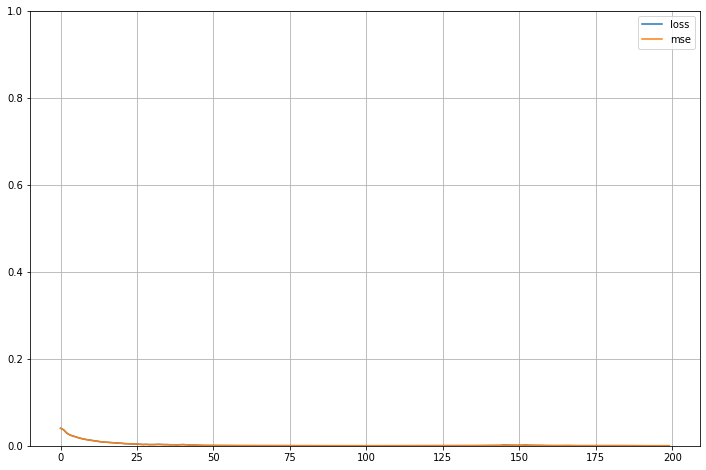

-----------------------------------------------------------------------
1/1 [==============================] - 5s 5s/step - loss: 0.0325 - mse: 0.0325
Loss                   :  [0.03253471106290817, 0.03253471106290817]


In [ ]:
# plot the learning curves
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

print("-----------------------------------------------------------------------")
# Evaluate the model
model_evaluate = model_tl.evaluate(X_test, y_test)
print("Loss                   : ",model_evaluate) 


In [11]:
# Load model
model_tl_1 = keras.models.load_model("/content/gdrive/MyDrive/model_tl.h5")

print("Done ...")


Done ...


Img :  0
y_test :  [203.0, 47.0, 11.313708498984761, 11.999999999999998]
pred   :  [182.47064208984375, 46.895328521728516, 11.229838371276855, 11.217788696289062]
IOU :  0.63


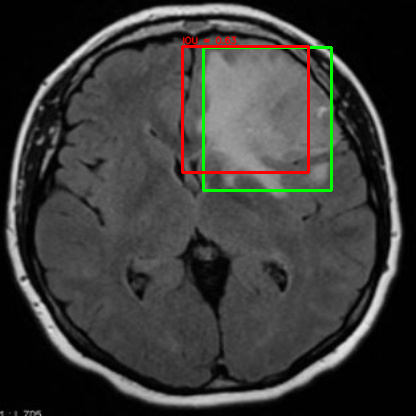

Img :  1
y_test :  [195.0, 77.0, 10.723805294763608, 11.532562594670797]
pred   :  [254.2435302734375, 156.31597900390625, 11.041024208068848, 11.765158653259277]
IOU :  0.11


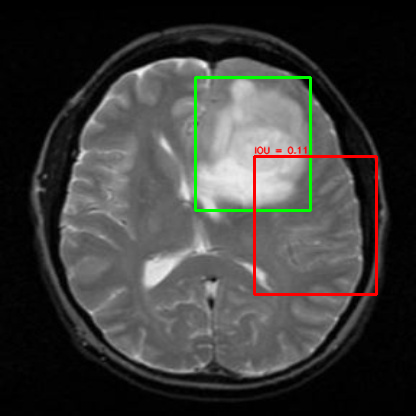

Img :  2
y_test :  [169.99999999999997, 212.99999999999997, 8.12403840463596, 7.937253933193771]
pred   :  [94.33489990234375, 116.15432739257812, 8.640398979187012, 8.427663803100586]
IOU :  0.0


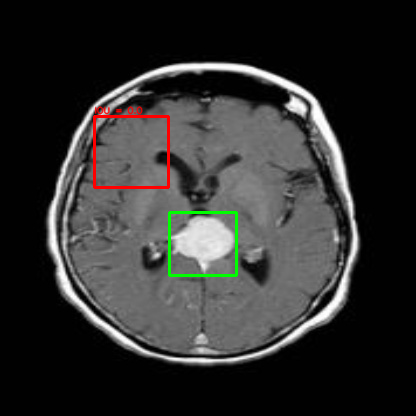

Img :  3
y_test :  [101.0, 229.0, 10.954451150103322, 11.789826122551595]
pred   :  [130.58261108398438, 115.07649230957031, 13.13607120513916, 13.039275169372559]
IOU :  0.13


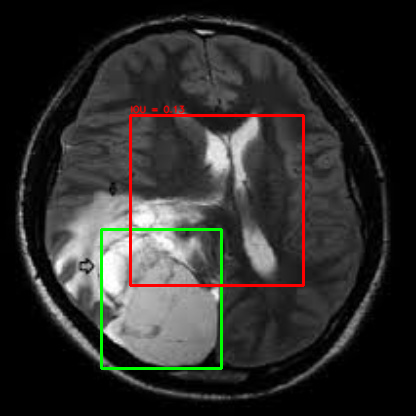

Img :  4
y_test :  [257.0, 302.0, 7.937253933193772, 7.615773105863909]
pred   :  [149.95054626464844, 162.3118896484375, 10.94660472869873, 8.5077486038208]
IOU :  0.0


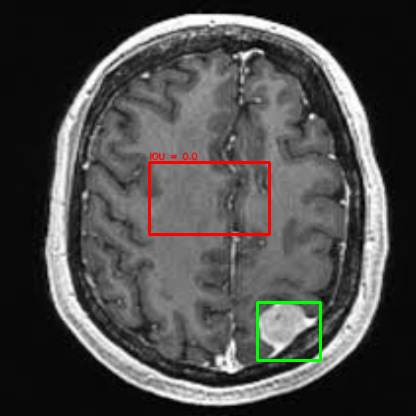

Img :  5
y_test :  [284.0, 126.0, 8.12403840463596, 6.855654600401044]
pred   :  [165.48004150390625, 126.83618927001953, 9.679010391235352, 9.912046432495117]
IOU :  0.0


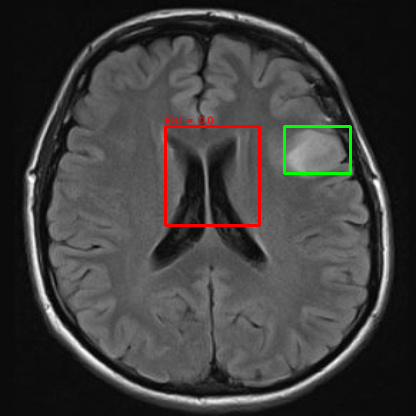

Img :  6
y_test :  [235.00000000000003, 182.0, 10.344080432788601, 11.999999999999998]
pred   :  [229.23995971679688, 181.42160034179688, 10.68272590637207, 12.182771682739258]
IOU :  0.91


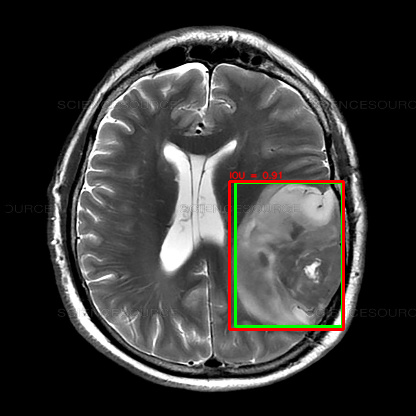

Img :  7
y_test :  [256.0, 225.0, 8.426149773176359, 8.831760866327848]
pred   :  [173.8336944580078, 228.35336303710938, 11.103311538696289, 10.396944046020508]
IOU :  0.2


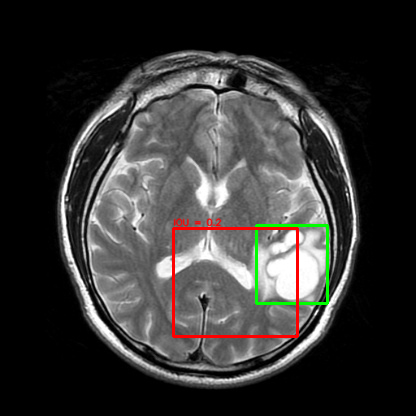

Img :  8
y_test :  [234.0, 212.99999999999997, 10.954451150103322, 10.14889156509222]
pred   :  [176.87591552734375, 95.33871459960938, 9.598931312561035, 8.594244003295898]
IOU :  0.0


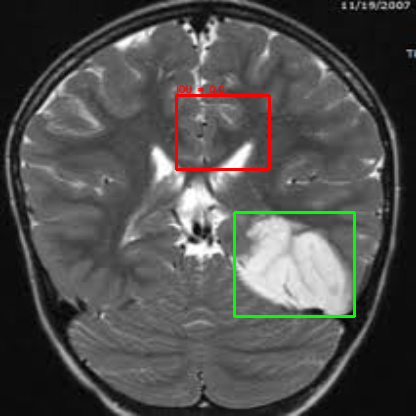

Img :  9
y_test :  [52.0, 141.0, 12.12435565298214, 11.313708498984763]
pred   :  [103.93705749511719, 130.5046844482422, 10.681110382080078, 11.78711986541748]
IOU :  0.55


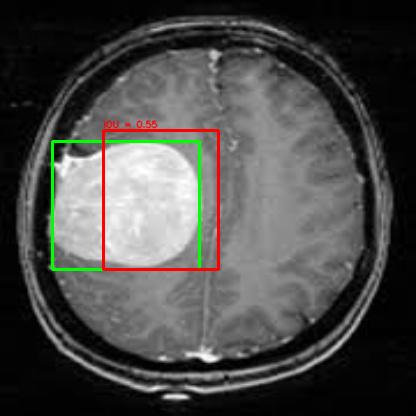

Img :  10
y_test :  [60.0, 74.0, 9.16515138991168, 10.63014581273465]
pred   :  [112.18077850341797, 48.62445831298828, 9.707077980041504, 10.09226131439209]
IOU :  0.15


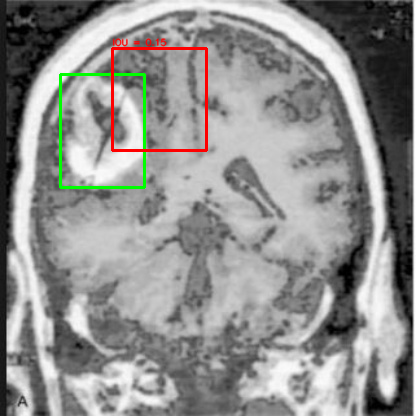

Img :  11
y_test :  [186.0, 79.0, 13.341664064126334, 12.083045973594574]
pred   :  [130.45091247558594, 103.79940032958984, 10.544231414794922, 10.199143409729004]
IOU :  0.18


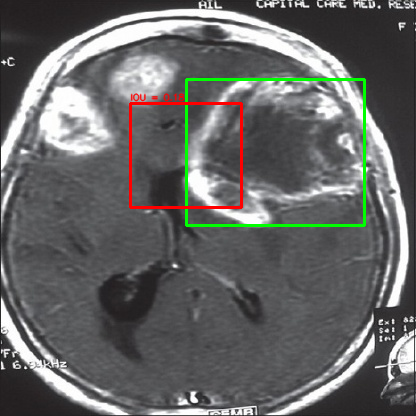

Img :  12
y_test :  [271.0, 202.0, 8.18535277187245, 7.280109889280518]
pred   :  [157.23060607910156, 180.7844696044922, 9.594993591308594, 8.998442649841309]
IOU :  0.0


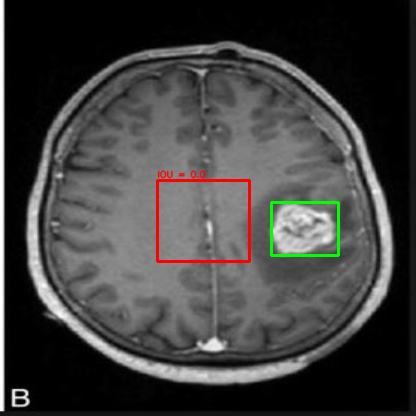

Img :  13
y_test :  [193.00000000000003, 94.0, 11.357816691600547, 11.269427669584644]
pred   :  [182.27511596679688, 49.4253044128418, 12.054553985595703, 12.374870300292969]
IOU :  0.57


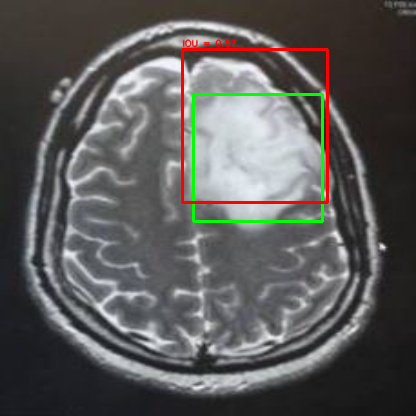

Img :  14
y_test :  [102.0, 127.00000000000001, 9.848857801796104, 11.313708498984763]
pred   :  [102.6980209350586, 123.0524673461914, 10.157304763793945, 11.42846965789795]
IOU :  0.9


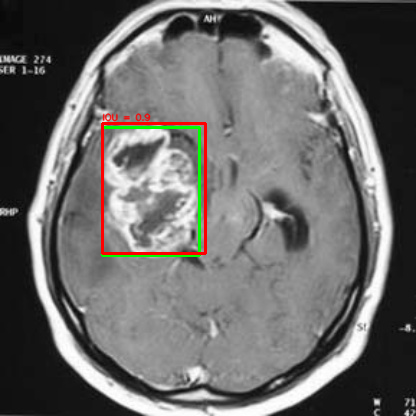

Img :  15
y_test :  [104.0, 35.0, 13.19090595827292, 12.328828005937952]
pred   :  [159.34605407714844, 71.36209106445312, 9.660232543945312, 8.88039779663086]
IOU :  0.28


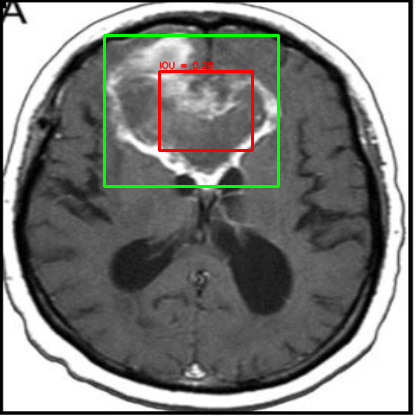

Img :  16
y_test :  [78.0, 160.0, 9.486832980505138, 11.532562594670797]
pred   :  [106.2070083618164, 134.05343627929688, 11.60315990447998, 11.8751802444458]
IOU :  0.3


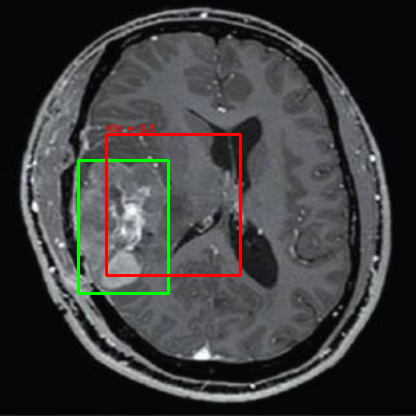

Img :  17
y_test :  [279.0, 161.0, 8.54400374531753, 9.591663046625438]
pred   :  [278.1103820800781, 162.87486267089844, 8.5458402633667, 9.586471557617188]
IOU :  0.95


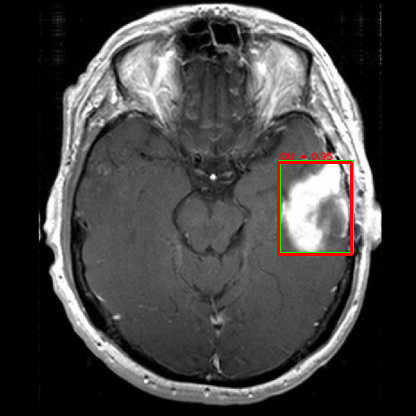

Img :  18
y_test :  [125.0, 182.0, 9.433981132056605, 9.486832980505138]
pred   :  [168.33731079101562, 120.58734130859375, 8.390603065490723, 8.772138595581055]
IOU :  0.06


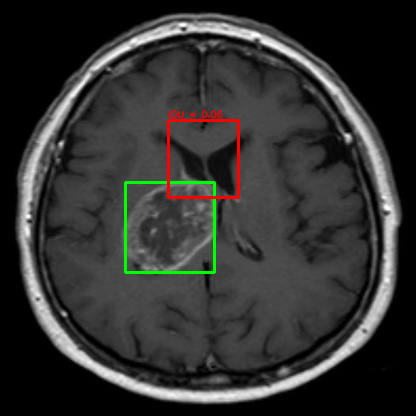

Img :  19
y_test :  [164.0, 292.0, 5.830951894845301, 6.164414002968976]
pred   :  [152.94168090820312, 270.9684753417969, 6.693919658660889, 6.575453281402588]
IOU :  0.29


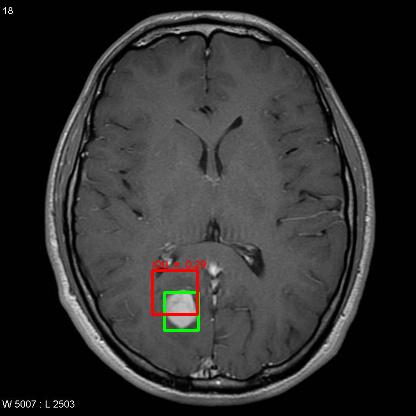

In [16]:
# Predict
pred = model_tl_1.predict(X_test)

#*******************************************************************************
def intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

for ind in range(len(y_test)):
  image_TL = X_test_raw[ind]
  box_test = y_test[ind]
  box_pred = pred[ind]
  
  box_test = box_test.reshape(1,-1)
  box_pred = box_pred.reshape(1,-1)
  box_test = min_max_scaler.inverse_transform(box_test).tolist()[0]
  box_pred = min_max_scaler.inverse_transform(box_pred).tolist()[0]
  
  print("Img : ",ind)
  print("y_test : ",box_test)
  print("pred   : ",box_pred)
  
  x_box_test, y_box_test = int(box_test[0]),int(box_test[1])
  w_box_test, h_box_test = int(box_test[0]+pow(box_test[2], 2)), int(box_test[1]+ pow(box_test[3], 2))

  x_box_pred, y_box_pred = int(box_pred[0]),int(box_pred[1])
  w_box_pred, h_box_pred = int(box_pred[0]+ pow(box_pred[2], 2)), int(box_pred[1]+ pow(box_pred[3], 2))

  boxA = [x_box_test, y_box_test, w_box_test, h_box_test]
  boxB = [x_box_pred, y_box_pred, w_box_pred, h_box_pred]

  iou = intersection_over_union(boxA, boxB)
  print("IOU : ",round(iou, 2))
  label = "IOU = "+str(round(iou, 2))

  cv2.putText(image_TL, label, (x_box_pred, y_box_pred-3), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,255),1,cv2.LINE_AA)	
  cv2.rectangle(image_TL, (x_box_test, y_box_test), (w_box_test, h_box_test), (0,255,0), 2)
  cv2.rectangle(image_TL, (x_box_pred, y_box_pred), (w_box_pred, h_box_pred), (0,0,255), 2)
  #image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
  cv2_imshow(image_TL)	



In [ ]:
# Save model
model_tl.save("/content/gdrive/MyDrive/model_tl.h5")

# Load model
# model_tl = keras.models.load_model("/content/gdrive/MyDrive/model_tl.h5")

print("Done ...")


Done ...
